In [1]:
import os
import datetime
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt

import sys
sys.path.append('/home/rluser/thesis_ws/src/ML/UTILITIES')
from PreProcessingFunctions import WS, WS_B

from OrganizeReports import compare_and_organize
from Performance_plotter import plot_f1_score_threshold, plot_precision_recall_curve, plot_confusion_matrix, plot_roc_curve
from ML_models_functions import to_save_model, free_gpu_memory

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report
from scipy.signal import butter, filtfilt
import traceback

import tensorflow
gpus = tensorflow.config.list_physical_devices('GPU')
if gpus:    
    for gpu in gpus:
        tensorflow.config.set_logical_device_configuration(
            gpu,
            [tensorflow.config.LogicalDeviceConfiguration(memory_limit=4*1024)])  # Adjust memory limit as needed


from tensorflow.keras.models     import Sequential, Model, load_model
from tensorflow.keras.layers     import Input, Conv1D, Conv2D, BatchNormalization
from tensorflow.keras.layers     import Flatten, Dense, MaxPooling1D, MaxPooling2D, GlobalMaxPooling1D
from tensorflow.keras.layers     import LeakyReLU, ReLU, Activation, Dropout, Lambda
from tensorflow.keras.layers     import concatenate, Concatenate
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.losses     import BinaryCrossentropy
from tensorflow.keras.metrics    import AUC
from tensorflow.keras.callbacks  import EarlyStopping

from tensorflow.keras.utils      import plot_model

def load_data(data_folder):
    X_data = []
    y_data = []
    
    # Traverse the data folder
    for file in os.listdir(data_folder):
        if file.endswith(".npz"):
            file_path = os.path.join(data_folder, file)
            data = np.load(file_path)
            X_data.append(data['X'])
            y_data.append(data['y'])
    
    # Stack the data into arrays
    X_data = np.vstack(X_data)
    y_data = np.hstack(y_data)
    
    return X_data, y_data


data_folder = '/home/rluser/thesis_ws/src/ML/DATA/1D_FPCA_GRIP_ScalNorm/'

X_data, y_data = load_data(data_folder)

# Check the shape of loaded data
print("X_data shape:", X_data.shape)
print("y_data shape:", y_data.shape)
print("X_data.[0] shape: ", X_data[0].shape)

TEST_SIZE = 0.4
X_train, X_temp, y_train, y_temp = train_test_split(X_data, y_data, test_size=TEST_SIZE, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"TOTAL DATA: {len(X_data)}  ||  Train = {100*(1-TEST_SIZE)}%  ||  Test = {100*TEST_SIZE}%")
print("Dimensions of X_train:", X_train.shape, "   ||  Dimensions of y_train:", y_train.shape)
print("Dimensions of X_test: ", X_test.shape, "   ||  Dimensions of y_test: ", y_test.shape)
print("Dimensions of X_val:  ", X_val.shape, "   ||  Dimensions of y_val:  ", y_val.shape)

IN_SHAPE = (WS_B, 2)
POSE_IN_SHAPE = (WS_B, 1)

2024-06-08 20:32:42.606143: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-08 20:32:43.398765: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-06-08 20:32:43.871303: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-08 20:32:43.897989: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. 

X_data shape: (1465, 800, 2)
y_data shape: (1465,)
X_data.[0] shape:  (800, 2)
TOTAL DATA: 1465  ||  Train = 60.0%  ||  Test = 40.0%
Dimensions of X_train: (879, 800, 2)    ||  Dimensions of y_train: (879,)
Dimensions of X_test:  (293, 800, 2)    ||  Dimensions of y_test:  (293,)
Dimensions of X_val:   (293, 800, 2)    ||  Dimensions of y_val:   (293,)


/home/rluser/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-06-08 20:32:44.345034: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-08 20:32:44.345289: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 77, 64)         │         5,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 38, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,297 (28.50 KB)

 Trainable params: 7,297 (28.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/78


I0000 00:00:1717871565.191871   13638 service.cc:145] XLA service 0x7aad1800b570 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1717871565.191923   13638 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce GTX 1650 Ti, Compute Capability 7.5
2024-06-08 20:32:45.212540: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-08 20:32:45.328369: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


 1/28 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.6562 - loss: 0.8016

I0000 00:00:1717871565.960975   13638 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.5088 - loss: 0.7486 - val_accuracy: 0.5188 - val_loss: 0.7045
Epoch 2/78
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5459 - loss: 0.6786 - val_accuracy: 0.6109 - val_loss: 0.6537
Epoch 3/78
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6185 - loss: 0.6562 - val_accuracy: 0.6246 - val_loss: 0.6430
Epoch 4/78
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6392 - loss: 0.6307 - val_accuracy: 0.6724 - val_loss: 0.6086
Epoch 5/78
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6949 - loss: 0.6072 - val_accuracy: 0.6246 - val_loss: 0.6053
Epoch 6/78
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6396 - loss: 0.6022 - val_accuracy: 0.6246 - val_loss: 0.5885
Epoch 7/78
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6742 - loss: 0.5838 - val_accuracy: 0.6792 - val_loss: 0.5853
Epoch 8/78
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6616 - loss: 0.5966 - val_accuracy: 0.6758 - val_loss: 0.5780
Ep

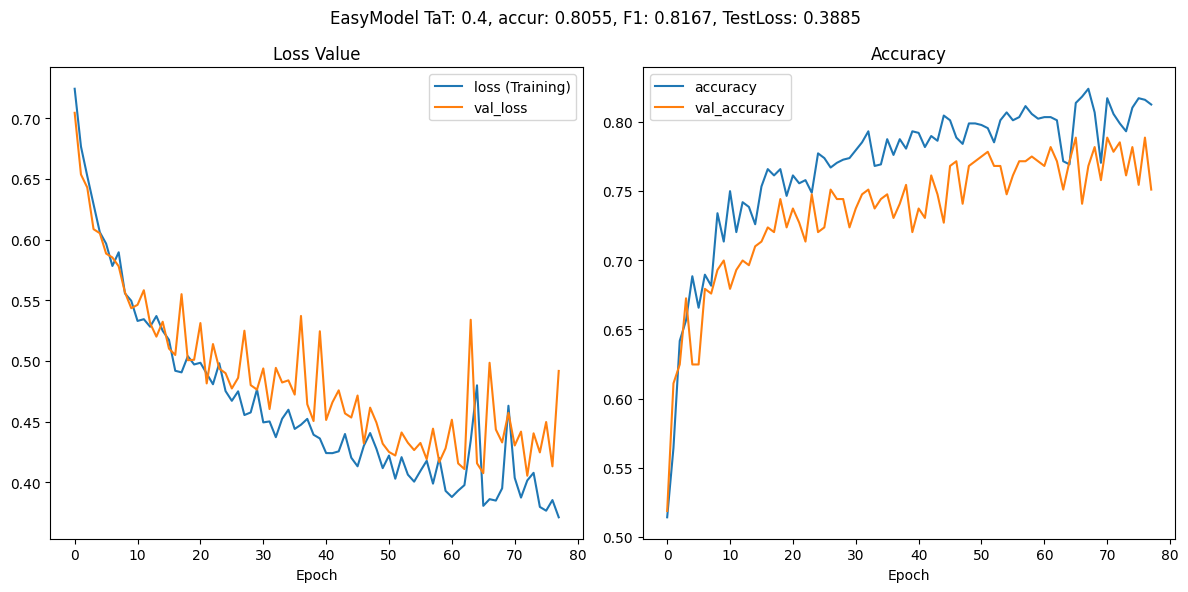

Train loss: 0.3711470365524292
Test val_loss: 0.4917839467525482
Train accuracy: 0.8122866749763489
Accuracy Score: 0.8054607508532423
F1 Score: 0.8167202572347267
Classification Report:
               precision    recall  f1-score   support

         0.0       0.82      0.77      0.79       142
         1.0       0.79      0.84      0.82       151

    accuracy                           0.81       293
   macro avg       0.81      0.80      0.80       293
weighted avg       0.81      0.81      0.81       293



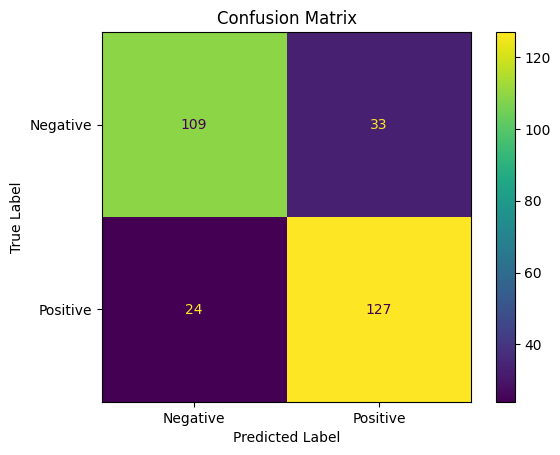

In [2]:
def build_easyModel():
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=40, strides=10, activation='relu', input_shape=IN_SHAPE))
    model.add(MaxPooling1D(pool_size=2))
    model.add(GlobalMaxPooling1D())
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

model = build_easyModel()
model.summary()
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

#TRAIN THE MODEL
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=78, batch_size=32, validation_data=(X_val, y_val), verbose=1,callbacks=[early_stopping])

loss, accuracy = model.evaluate(X_test, y_test)

# Predict labels for test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

f1 = f1_score(y_test, y_pred_binary)
accuracy = accuracy_score(y_test, y_pred_binary)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()
# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.suptitle(f"EasyModel TaT: {TEST_SIZE}, accur: {accuracy:.4f}, F1: {f1:.4f}, TestLoss: {loss:.4f}")
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("Train accuracy:", history.history["accuracy"][-1])
print("Accuracy Score:", accuracy)

print("F1 Score:", f1)
print("Classification Report:\n", classification_report(y_test, y_pred_binary))
plot_confusion_matrix(y_test, y_pred_binary)

# STILL UNIQUE MODEL, Single BRANCH

/home/rluser/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 77, 128)        │        10,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 38, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 15, 128)        │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 15, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 7, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 2, 256)         │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ (None, 256)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 338,689 (1.29 MB)

 Trainable params: 338,689 (1.29 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accuracy: 0.5263 - loss: 0.6931 - val_accuracy: 0.6314 - val_loss: 0.6268
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6461 - loss: 0.6284 - val_accuracy: 0.6894 - val_loss: 0.5714
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7039 - loss: 0.5468 - val_accuracy: 0.7372 - val_loss: 0.4922
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7408 - loss: 0.4807 - val_accuracy: 0.7474 - val_loss: 0.4826
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7965 - loss: 0.4454 - val_accuracy: 0.7577 - val_loss: 0.4624
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7713 - loss: 0.4121 - val_accuracy: 0.8396 - val_loss: 0.4165
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8100 - loss: 0.4067 - val_accuracy: 0.7645 - val_loss: 0.4460
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8286 - loss: 0.3470 - val_accuracy: 0.7952 - val_los

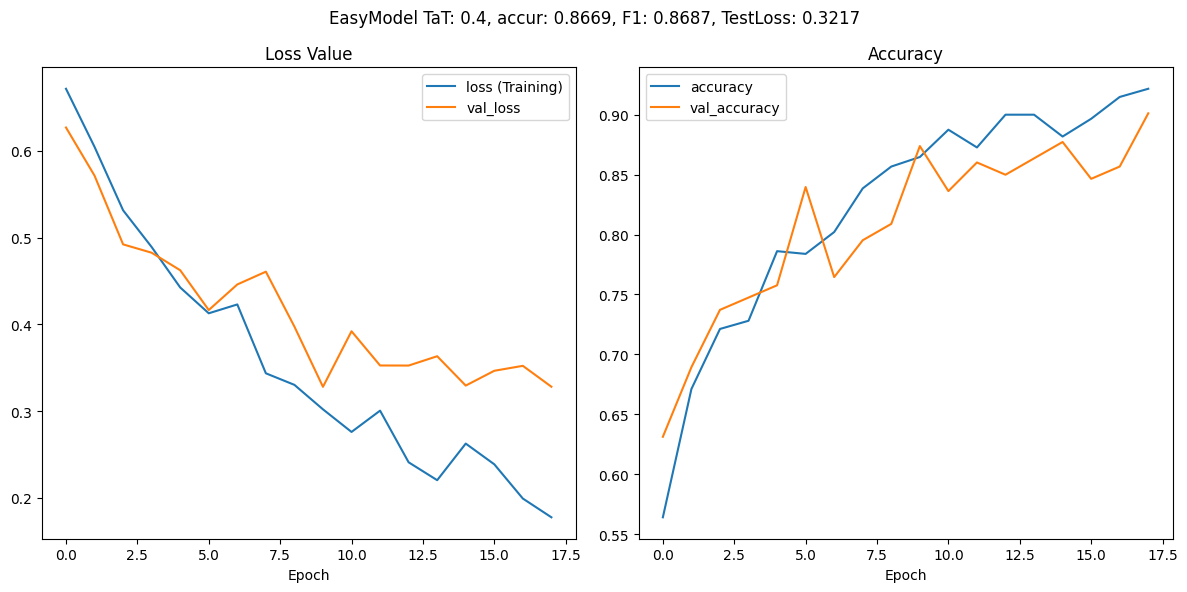

Train loss: 0.17775151133537292
Test val_loss: 0.3282039165496826
Train accuracy: 0.9215016961097717
Accuracy Score: 0.8668941979522184
F1 Score: 0.8686868686868687
Classification Report:
               precision    recall  f1-score   support

         0.0       0.85      0.88      0.87       142
         1.0       0.88      0.85      0.87       151

    accuracy                           0.87       293
   macro avg       0.87      0.87      0.87       293
weighted avg       0.87      0.87      0.87       293



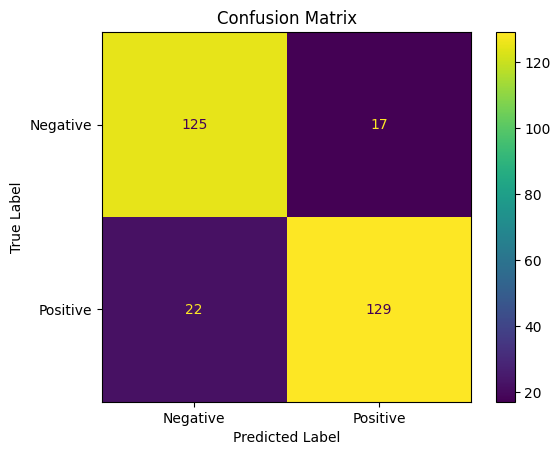

In [3]:
def build_easyModel():
    model = Sequential()
    model.add(Conv1D(128, kernel_size=40, strides=10, activation='relu', input_shape=IN_SHAPE))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(128, kernel_size=10, strides=2, activation='relu'))
    model.add(Dropout(0.2))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(256, kernel_size=4,strides=2, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid')) # activation=(lambda x: x>0)
    return model

model = build_easyModel()
model.summary()
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

#TRAIN THE MODEL
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=1,callbacks=[early_stopping])

loss, accuracy = model.evaluate(X_test, y_test)

# Predict labels for test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

f1 = f1_score(y_test, y_pred_binary)
accuracy = accuracy_score(y_test, y_pred_binary)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()
# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.suptitle(f"EasyModel TaT: {TEST_SIZE}, accur: {accuracy:.4f}, F1: {f1:.4f}, TestLoss: {loss:.4f}")
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("Train accuracy:", history.history["accuracy"][-1])
print("Accuracy Score:", accuracy)

print("F1 Score:", f1)
print("Classification Report:\n", classification_report(y_test, y_pred_binary))
plot_confusion_matrix(y_test, y_pred_binary)

# SINGLE BRANCH, 5 LAYERS

/home/rluser/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)               │ (None, 77, 128)        │        10,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 38, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 16, 128)        │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 8, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 5, 128)         │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 2, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 1, 128)         │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_2          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 248,449 (970.50 KB)

 Trainable params: 248,449 (970.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - accuracy: 0.5761 - loss: 0.6750 - val_accuracy: 0.7031 - val_loss: 0.5807
Epoch 2/40
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6903 - loss: 0.5886 - val_accuracy: 0.7031 - val_loss: 0.5291
Epoch 3/40
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7305 - loss: 0.5352 - val_accuracy: 0.7270 - val_loss: 0.5031
Epoch 4/40
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7600 - loss: 0.4880 - val_accuracy: 0.7406 - val_loss: 0.5029
Epoch 5/40
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7824 - loss: 0.4101 - val_accuracy: 0.7440 - val_loss: 0.4353
Epoch 6/40
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7852 - loss: 0.4131 - val_accuracy: 0.7850 - val_loss: 0.4365
Epoch 7/40
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8312 - loss: 0.3607 - val_accuracy: 0.7952 - val_loss: 0.4120
Epoch 8/40
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8388 - loss: 0.3405 - val_accuracy: 0.8191 - val_loss

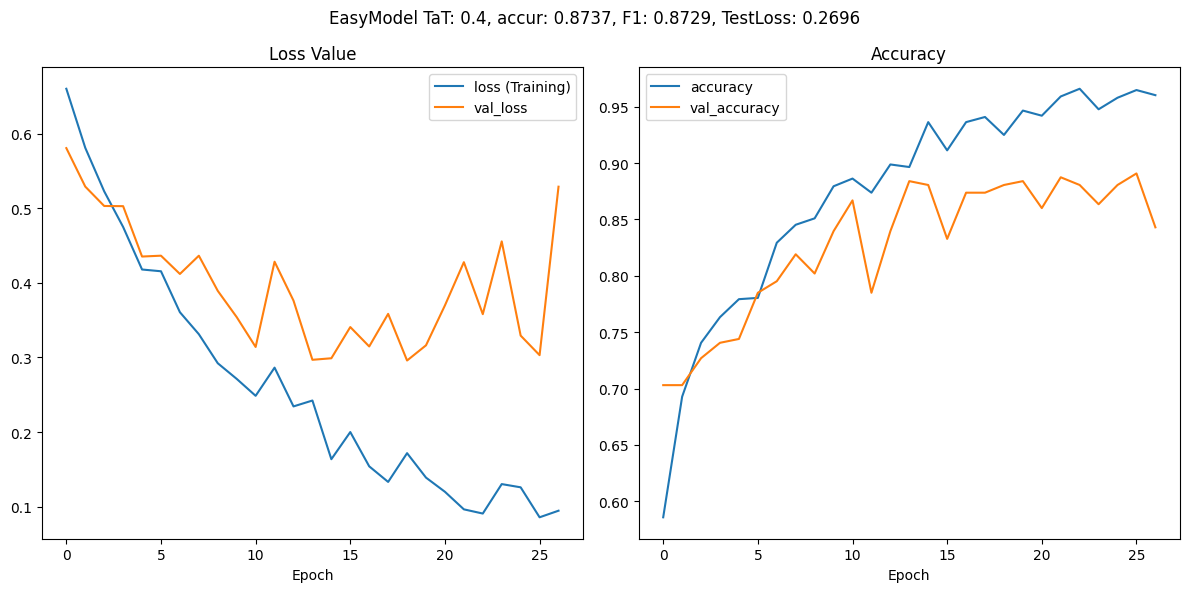

Train loss: 0.09454692900180817
Test val_loss: 0.5289701819419861
Train accuracy: 0.9601820111274719
Accuracy Score: 0.8737201365187713
F1 Score: 0.872852233676976
Classification Report:
               precision    recall  f1-score   support

         0.0       0.84      0.91      0.87       142
         1.0       0.91      0.84      0.87       151

    accuracy                           0.87       293
   macro avg       0.88      0.87      0.87       293
weighted avg       0.88      0.87      0.87       293



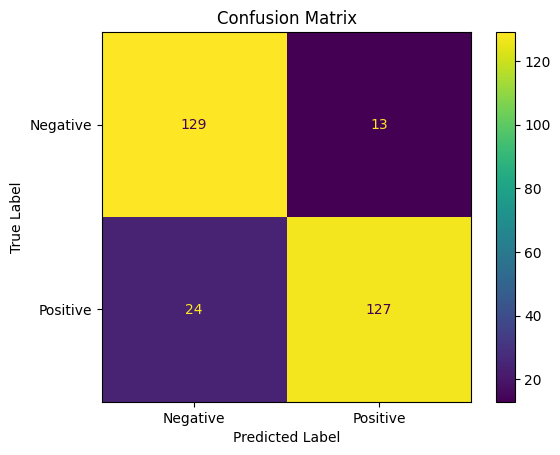

In [4]:
def build_easyModel():
    model = Sequential()
    model.add(Conv1D(128, kernel_size=40, strides=10, activation='relu', input_shape=IN_SHAPE))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(128, kernel_size=8, strides=2, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(128, kernel_size=4, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(128, kernel_size=2, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid')) 

    return model

model = build_easyModel()
model.summary()
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

#TRAIN THE MODEL
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=40, batch_size=32, validation_data=(X_val, y_val), verbose=1,callbacks=[early_stopping])

loss, accuracy = model.evaluate(X_test, y_test)

# Predict labels for test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

f1 = f1_score(y_test, y_pred_binary)
accuracy = accuracy_score(y_test, y_pred_binary)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()
# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.suptitle(f"EasyModel TaT: {TEST_SIZE}, accur: {accuracy:.4f}, F1: {f1:.4f}, TestLoss: {loss:.4f}")
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("Train accuracy:", history.history["accuracy"][-1])
print("Accuracy Score:", accuracy)

print("F1 Score:", f1)
print("Classification Report:\n", classification_report(y_test, y_pred_binary))
plot_confusion_matrix(y_test, y_pred_binary)

# SEPARATED MODELS F+P

/home/rluser/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional_42"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ force_input         │ (None, 800, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pose_input          │ (None, 800, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 64)        │    166,912 │ force_input[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_4        │ (None, 32)        │     51,872 │ pose_input[0][0]  │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 96)        │          0 │ sequential_3[0][… │
│ (Concatenate)       │                   │            │ sequential_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 64)        │      6,208 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 1)         │         65 │ dense_8[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 225,057 (879.13 KB)

 Trainable params: 225,057 (879.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.5468 - loss: 0.6893 - val_accuracy: 0.7031 - val_loss: 0.6092
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6455 - loss: 0.6188 - val_accuracy: 0.7133 - val_loss: 0.5655
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6911 - loss: 0.5687 - val_accuracy: 0.6621 - val_loss: 0.5986
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7008 - loss: 0.5514 - val_accuracy: 0.7474 - val_loss: 0.4558
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7800 - loss: 0.4361 - val_accuracy: 0.7611 - val_loss: 0.4724
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7586 - loss: 0.4577 - val_accuracy: 0.7782 - val_loss: 0.4160
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8140 - loss: 0.3846 - val_accuracy: 0.7031 - val_loss: 0.5431
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7971 - loss: 0.4079 - val_accuracy: 0.8055 - val_loss

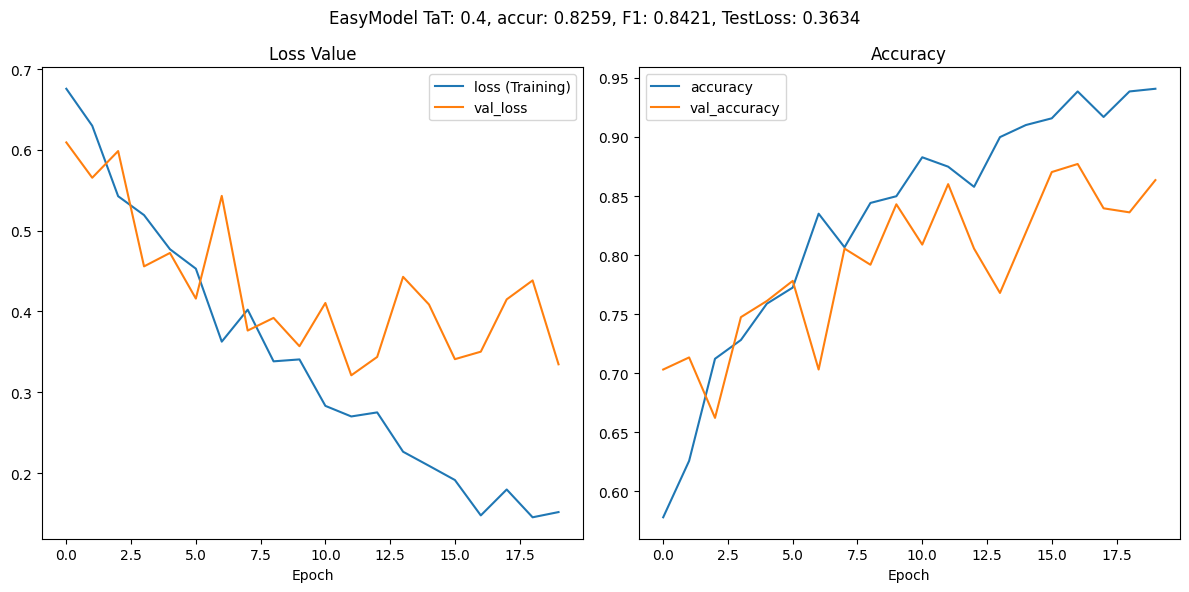

Train loss: 0.15177051723003387
Test val_loss: 0.3346409797668457
Train accuracy: 0.9408418536186218
Accuracy Score: 0.825938566552901
F1 Score: 0.8421052631578947
Classification Report:
               precision    recall  f1-score   support

         0.0       0.88      0.75      0.81       142
         1.0       0.79      0.90      0.84       151

    accuracy                           0.83       293
   macro avg       0.83      0.82      0.82       293
weighted avg       0.83      0.83      0.82       293



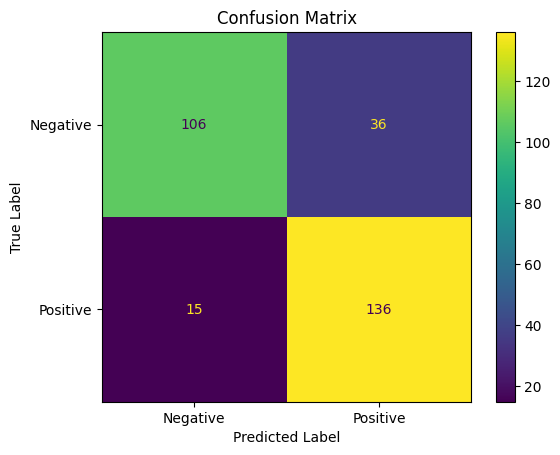

In [5]:
def build_SeparatedEASYmodel(F_input_shape, P_input_shape):
    force_input = Input(shape=F_input_shape, name='force_input')
    Fbranch = Sequential()
    Fbranch.add(Conv1D(64, kernel_size=40, strides=10, activation='relu', input_shape=F_input_shape))
    Fbranch.add(MaxPooling1D(pool_size=2))
    Fbranch.add(Conv1D(128, kernel_size=10,strides=4, activation='relu'))
    Fbranch.add(MaxPooling1D(pool_size=2))
    Fbranch.add(Conv1D(256, kernel_size=2, activation='relu'))
    Fbranch.add(GlobalMaxPooling1D())
    Fbranch.add(Flatten())
    Fbranch.add(Dense(64, activation='relu'))
    outF = Fbranch(force_input)

    pose_input = Input(shape=F_input_shape, name='pose_input')
    Pbranch = Sequential()
    Pbranch.add(Conv1D(64, kernel_size=40, strides=10, activation='relu', input_shape=P_input_shape))
    Pbranch.add(MaxPooling1D(pool_size=2))
    Pbranch.add(Conv1D(64, kernel_size=10, strides=4, activation='relu'))
    Pbranch.add(MaxPooling1D(pool_size=2))
    Pbranch.add(Flatten())
    Pbranch.add(Dense(32, activation='relu'))
    outP = Pbranch(pose_input)
    
    merged = concatenate([outF, outP])
    merged = Dense(64, activation='relu')(merged)
    merged = Dense(1, activation='sigmoid')(merged)
    separated_model = Model(inputs=[force_input, pose_input], outputs=merged)
    
    return separated_model
    
force_input_shape = (WS_B, 1)
pose_input_shape = POSE_IN_SHAPE
model = build_SeparatedEASYmodel(force_input_shape, pose_input_shape)
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# SPLITTING DATASET FORCE+POSE
X_force_data = X_data[:, :, :1]
X_pose_data  = X_data[:, :, 1:]

X_train_force,  X_temp_force = train_test_split(X_force_data, test_size=TEST_SIZE, random_state=42)
X_val_force,    X_test_force = train_test_split(X_temp_force , test_size=0.5, random_state=42)

X_train_pose,   X_temp_pose  = train_test_split(X_pose_data, test_size=TEST_SIZE, random_state=42)
X_val_pose,     X_test_pose  = train_test_split(X_temp_pose , test_size=0.5, random_state=42)

X_train = [X_train_force,   X_train_pose]
X_val   = [X_val_force,     X_val_pose]
X_test  = [X_test_force,    X_test_pose]

y_train, y_temp = train_test_split(y_data, test_size=TEST_SIZE, random_state=42)
y_val  , y_test = train_test_split(y_temp, test_size=0.5, random_state=42)

#TRAIN THE MODEL
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=1,callbacks=[early_stopping])
loss, accuracy = model.evaluate(X_test, y_test)

y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

f1 = f1_score(y_test, y_pred_binary)
accuracy = accuracy_score(y_test, y_pred_binary)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()
# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.suptitle(f"EasyModel TaT: {TEST_SIZE}, accur: {accuracy:.4f}, F1: {f1:.4f}, TestLoss: {loss:.4f}")
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("Train accuracy:", history.history["accuracy"][-1])
print("Accuracy Score:", accuracy)

print("F1 Score:", f1)
print("Classification Report:\n", classification_report(y_test, y_pred_binary))
    
plot_confusion_matrix(y_test, y_pred_binary)

In [6]:
# model_name = "1D_GRIPA_F+Popt_BranchedEasy94_#2"
# to_save_model(model, history, loss, accuracy, f1, model_name, y_test, y_pred_binary, build_SeparatedEASYmodel)
# #model.save(f"{model_name}.h5")
# from tensorflow.keras.models import save_model
# save_dir = "saved_models/"
# os.makedirs(save_dir, exist_ok=True)
# model_path = os.path.join(save_dir, f"{model_name}.keras")
# save_model(model, model_path)

# COMPLEX SEPARATED MODEL

/home/rluser/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional_68"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ force_input         │ (None, 800, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pose_input          │ (None, 800, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_5        │ (None, 64)        │    339,072 │ force_input[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_6        │ (None, 64)        │    119,488 │ force_input[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_7        │ (None, 16)        │     58,000 │ pose_input[0][0]  │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 144)       │          0 │ sequential_5[0][… │
│ (Concatenate)       │                   │            │ sequential_6[0][… │
│                     │                   │            │ sequential_7[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 144)       │          0 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 64)        │      9,280 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 1)         │         65 │ dense_14[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 525,905 (2.01 MB)

 Trainable params: 525,905 (2.01 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/44
28/28 ━━━━━━━━━━━━━━━━━━━━ 18s 288ms/step - accuracy: 0.5465 - loss: 0.6848 - val_accuracy: 0.4812 - val_loss: 0.7597
Epoch 2/44
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6039 - loss: 0.6573 - val_accuracy: 0.7338 - val_loss: 0.5715
Epoch 3/44
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6748 - loss: 0.5893 - val_accuracy: 0.7645 - val_loss: 0.5222
Epoch 4/44
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7115 - loss: 0.5377 - val_accuracy: 0.7918 - val_loss: 0.4455
Epoch 5/44
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7294 - loss: 0.5116 - val_accuracy: 0.7850 - val_loss: 0.4631
Epoch 6/44
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7460 - loss: 0.4765 - val_accuracy: 0.8396 - val_loss: 0.3557
Epoch 7/44
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7695 - loss: 0.4533 - val_accuracy: 0.8191 - val_loss: 0.3557
Epoch 8/44
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8440 - loss: 0.3563 - val_accuracy: 0.8430 -

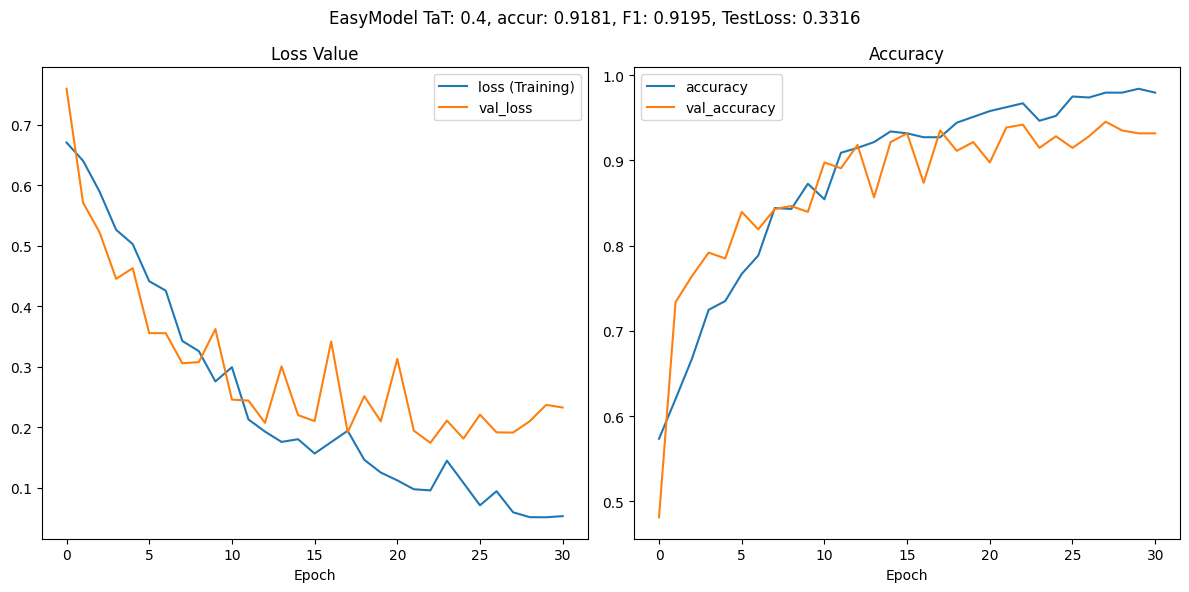

Train loss: 0.05314691364765167
Test val_loss: 0.23272182047367096
Train accuracy: 0.979522168636322
Accuracy Score: 0.9180887372013652
F1 Score: 0.9194630872483222
Classification Report:
               precision    recall  f1-score   support

         0.0       0.90      0.93      0.92       142
         1.0       0.93      0.91      0.92       151

    accuracy                           0.92       293
   macro avg       0.92      0.92      0.92       293
weighted avg       0.92      0.92      0.92       293



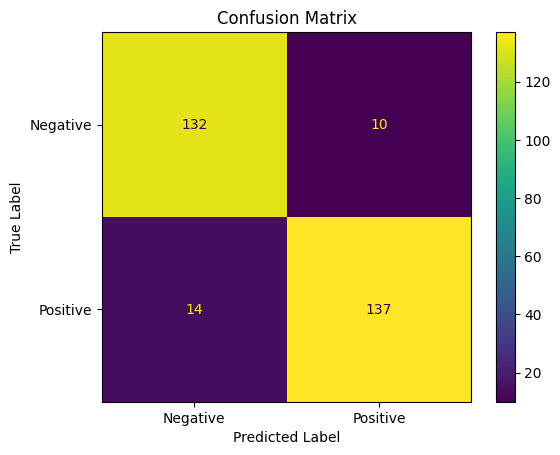

In [7]:
def build_SeparatedEASYmodel(F_input_shape, P_input_shape):
    force_input = Input(shape=F_input_shape, name='force_input')
    Fbranch1 = Sequential()
    Fbranch1.add(Conv1D(64, kernel_size=40, strides=8, activation='relu', input_shape=F_input_shape))
    Fbranch1.add(MaxPooling1D(pool_size=2))
    Fbranch1.add(Conv1D(128, kernel_size=20, strides=2, activation='relu'))
    Fbranch1.add(MaxPooling1D(pool_size=2))
    Fbranch1.add(Conv1D(256, kernel_size=4, activation='relu'))
    Fbranch1.add(GlobalMaxPooling1D())
    Fbranch1.add(Dense(128, activation='relu'))
    Fbranch1.add(Dropout(0.2))
    Fbranch1.add(Dense(64, activation='relu'))
    outF1 = Fbranch1(force_input)

    Fbranch2 = Sequential()
    Fbranch2.add(Conv1D(128, kernel_size=2,  activation='relu', input_shape=F_input_shape))
    Fbranch2.add(MaxPooling1D(pool_size=2))
    Fbranch2.add(Conv1D(64, kernel_size=8, strides=2, activation='relu'))
    Fbranch2.add(MaxPooling1D(pool_size=2))
    Fbranch2.add(Conv1D(128, kernel_size=4, activation='relu'))
    Fbranch2.add(Conv1D(64, kernel_size=2, activation='relu'))
    Fbranch2.add(GlobalMaxPooling1D())
    Fbranch2.add(Dropout(0.1))
    Fbranch2.add(Dense(64, activation='relu'))
    outF2 = Fbranch2(force_input)
    
    pose_input = Input(shape=F_input_shape, name='pose_input')
    Pbranch = Sequential()
    Pbranch.add(Conv1D(64, kernel_size=40, strides=10, activation='relu', input_shape=P_input_shape))
    Pbranch.add(MaxPooling1D(pool_size=2))
    Pbranch.add(Conv1D(64, kernel_size=10, activation='relu'))
    Pbranch.add(MaxPooling1D(pool_size=2))
    Pbranch.add(Flatten())
    Pbranch.add(Dense(16, activation='relu'))
    outP = Pbranch(pose_input)
    
    merged = concatenate([outF1, outF2, outP])
    merged = Dropout(0.1)(merged)
    merged = Dense(64, activation='relu')(merged)
    merged = Dense(1, activation='sigmoid')(merged)
    separated_model = Model(inputs=[force_input, force_input, pose_input], outputs=merged)
    
    return separated_model

force_input_shape = (WS_B, 1)
pose_input_shape = POSE_IN_SHAPE
model = build_SeparatedEASYmodel(force_input_shape, pose_input_shape)
model.compile(optimizer=AdamW(), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# SPLITTING DATASET FORCE+POSE
X_force_data = X_data[:, :, :1]
X_pose_data  = X_data[:, :, 1:]

X_train_force,  X_temp_force = train_test_split(X_force_data, test_size=TEST_SIZE, random_state=42)
X_val_force,    X_test_force = train_test_split(X_temp_force , test_size=0.5, random_state=42)

X_train_pose,   X_temp_pose  = train_test_split(X_pose_data, test_size=TEST_SIZE, random_state=42)
X_val_pose,     X_test_pose  = train_test_split(X_temp_pose , test_size=0.5, random_state=42)

X_train = [X_train_force,   X_train_force, X_train_pose]
X_val   = [X_val_force,     X_val_force,   X_val_pose]
X_test  = [X_test_force,    X_test_force,  X_test_pose]

y_train, y_temp = train_test_split(y_data, test_size=TEST_SIZE, random_state=42)
y_val  , y_test = train_test_split(y_temp, test_size=0.5, random_state=42)

#TRAIN THE MODEL
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=44, batch_size=32, validation_data=(X_val, y_val), verbose=1,callbacks=[early_stopping])
loss, accuracy = model.evaluate(X_test, y_test)

y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

f1 = f1_score(y_test, y_pred_binary)
accuracy = accuracy_score(y_test, y_pred_binary)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()
# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.suptitle(f"EasyModel TaT: {TEST_SIZE}, accur: {accuracy:.4f}, F1: {f1:.4f}, TestLoss: {loss:.4f}")
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("Train accuracy:", history.history["accuracy"][-1])
print("Accuracy Score:", accuracy)

print("F1 Score:", f1)
print("Classification Report:\n", classification_report(y_test, y_pred_binary))
plot_confusion_matrix(y_test, y_pred_binary)
    

In [8]:
# model_name = "1D_GRIPA_F+P_BranchedComplex99_SoGoood"
# to_save_model(model, history, loss, accuracy, f1, model_name, y_test, y_pred_binary, build_SeparatedEASYmodel)
# #model.save(f"{model_name}.h5")
# from tensorflow.keras.models import save_model
# save_dir = "saved_models/"
# os.makedirs(save_dir, exist_ok=True)
# model_path = os.path.join(save_dir, f"{model_name}.keras")
# save_model(model, model_path)

# ABOVE MODEL BUT WITH FULL TRAINING

/home/rluser/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional_94"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ force_input         │ (None, 800, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pose_input          │ (None, 800, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_8        │ (None, 64)        │    339,072 │ force_input[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_9        │ (None, 64)        │    119,488 │ force_input[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_10       │ (None, 16)        │     58,000 │ pose_input[0][0]  │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 144)       │          0 │ sequential_8[0][… │
│ (Concatenate)       │                   │            │ sequential_9[0][… │
│                     │                   │            │ sequential_10[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 144)       │          0 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 64)        │      9,280 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 1)         │         65 │ dense_20[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 525,905 (2.01 MB)

 Trainable params: 525,905 (2.01 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/46
19/19 ━━━━━━━━━━━━━━━━━━━━ 18s 382ms/step - accuracy: 0.5325 - loss: 0.6852
Epoch 2/46
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6474 - loss: 0.6172
Epoch 3/46
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6873 - loss: 0.5721
Epoch 4/46
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7136 - loss: 0.5180
Epoch 5/46
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7549 - loss: 0.4838
Epoch 6/46
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7536 - loss: 0.4454
Epoch 7/46
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8030 - loss: 0.3996
Epoch 8/46
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8236 - loss: 0.3573
Epoch 9/46
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8604 - loss: 0.2957
Epoch 10/46
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8956 - loss: 0.2575
Epoch 11/46
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8988 - loss: 0.2325
Epoch 12/46
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accurac

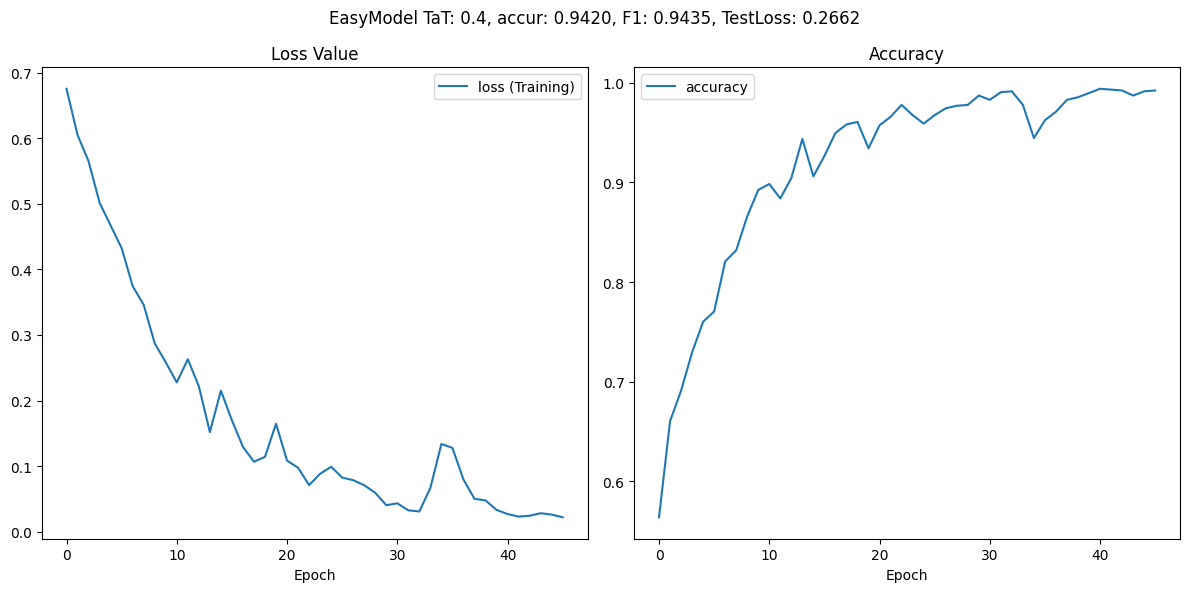

Train loss: 0.022004244849085808
Test loss: 0.2662297189235687
Train accuracy: 0.9923208355903625
Accuracy Score: 0.9419795221843004
F1 Score: 0.9435215946843853
Classification Report:
               precision    recall  f1-score   support

         0.0       0.94      0.94      0.94       142
         1.0       0.95      0.94      0.94       151

    accuracy                           0.94       293
   macro avg       0.94      0.94      0.94       293
weighted avg       0.94      0.94      0.94       293



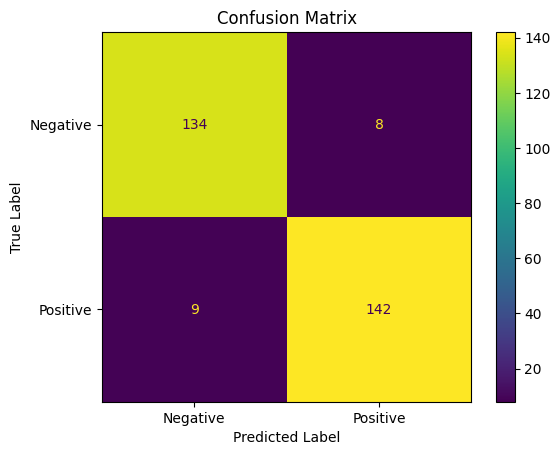

In [9]:
def build_SeparatedEASYmodel(F_input_shape, P_input_shape):
    force_input = Input(shape=F_input_shape, name='force_input')
    Fbranch1 = Sequential()
    Fbranch1.add(Conv1D(64, kernel_size=40, strides=8, activation='relu', input_shape=F_input_shape))
    Fbranch1.add(MaxPooling1D(pool_size=2))
    Fbranch1.add(Conv1D(128, kernel_size=20, strides=2, activation='relu'))
    Fbranch1.add(MaxPooling1D(pool_size=2))
    Fbranch1.add(Conv1D(256, kernel_size=4, activation='relu'))
    Fbranch1.add(GlobalMaxPooling1D())
    Fbranch1.add(Dense(128, activation='relu'))
    Fbranch1.add(Dropout(0.2))
    Fbranch1.add(Dense(64, activation='relu'))
    outF1 = Fbranch1(force_input)

    Fbranch2 = Sequential()
    Fbranch2.add(Conv1D(128, kernel_size=2,  activation='relu', input_shape=F_input_shape))
    Fbranch2.add(MaxPooling1D(pool_size=2))
    Fbranch2.add(Conv1D(64, kernel_size=8, strides=2, activation='relu'))
    Fbranch2.add(MaxPooling1D(pool_size=2))
    Fbranch2.add(Conv1D(128, kernel_size=4, activation='relu'))
    Fbranch2.add(Conv1D(64, kernel_size=2, activation='relu'))
    Fbranch2.add(GlobalMaxPooling1D())
    Fbranch2.add(Dropout(0.1))
    Fbranch2.add(Dense(64, activation='relu'))
    outF2 = Fbranch2(force_input)
    
    pose_input = Input(shape=F_input_shape, name='pose_input')
    Pbranch = Sequential()
    Pbranch.add(Conv1D(64, kernel_size=40, strides=10, activation='relu', input_shape=P_input_shape))
    Pbranch.add(MaxPooling1D(pool_size=2))
    Pbranch.add(Conv1D(64, kernel_size=10, activation='relu'))
    Pbranch.add(MaxPooling1D(pool_size=2))
    Pbranch.add(Flatten())
    Pbranch.add(Dense(16, activation='relu'))
    outP = Pbranch(pose_input)
    
    merged = concatenate([outF1, outF2, outP])
    merged = Dropout(0.1)(merged)
    merged = Dense(64, activation='relu')(merged)
    merged = Dense(1, activation='sigmoid')(merged)
    separated_model = Model(inputs=[force_input, force_input, pose_input], outputs=merged)
    
    return separated_model

force_input_shape = (WS_B, 1)
pose_input_shape = POSE_IN_SHAPE
model = build_SeparatedEASYmodel(force_input_shape, pose_input_shape)
model.compile(optimizer=AdamW(), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# SPLITTING DATASET FORCE+POSE
X_force_data = X_data[:, :, :1]
X_pose_data = X_data[:, :, 1:]

# Splitting force data
X_train_force, X_test_force, y_train, y_test = train_test_split(X_force_data, y_data, test_size=0.2, random_state=42)

# Splitting pose data
X_train_pose, X_test_pose, _, _ = train_test_split(X_pose_data, y_data, test_size=0.2, random_state=42)

# Concatenating the labels for the new training dataset
X_train_force_full = X_train_force
X_train_pose_full = X_train_pose

# TRAIN THE MODEL
early_stopping = EarlyStopping(monitor='loss', patience=8, restore_best_weights=True)
history = model.fit([X_train_force_full, X_train_force_full, X_train_pose_full], y_train, epochs=46, batch_size=64, verbose=1, callbacks=[early_stopping])
loss, accuracy = model.evaluate([X_test_force, X_test_force, X_test_pose], y_test)

y_pred = model.predict([X_test_force, X_test_force, X_test_pose])
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

f1 = f1_score(y_test, y_pred_binary)
accuracy = accuracy_score(y_test, y_pred_binary)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()
# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.suptitle(f"EasyModel TaT: {TEST_SIZE}, accur: {accuracy:.4f}, F1: {f1:.4f}, TestLoss: {loss:.4f}")
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test loss:", loss)
print("Train accuracy:", history.history["accuracy"][-1])
print("Accuracy Score:", accuracy)
print("F1 Score:", f1)
print("Classification Report:\n", classification_report(y_test, y_pred_binary))
plot_confusion_matrix(y_test, y_pred_binary)


In [10]:
# model_name = "1D_GRIPA_F+P_Branched98_Train_NoVal"
# #to_save_model(model, history, loss, accuracy, f1, model_name, y_test, y_pred_binary, build_SeparatedEASYmodel)
# #model.save(f"{model_name}.h5")
# from tensorflow.keras.models import save_model
# save_dir = "saved_models/"
# os.makedirs(save_dir, exist_ok=True)
# model_path = os.path.join(save_dir, f"{model_name}.keras")
# save_model(model, model_path)

# TRYING TO IMPROVE THE ABOVE MODEL

/home/rluser/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional_129"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ force_input         │ (None, 800, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pose_input          │ (None, 800, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_11       │ (None, 64)        │    339,072 │ force_input[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_12       │ (None, 64)        │    119,488 │ force_input[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_13       │ (None, 64)        │    136,896 │ force_input[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_14       │ (None, 16)        │     58,000 │ pose_input[0][0]  │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 208)       │          0 │ sequential_11[0]… │
│ (Concatenate)       │                   │            │ sequential_12[0]… │
│                     │                   │            │ sequential_13[0]… │
│                     │                   │            │ sequential_14[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 208)       │          0 │ concatenate_3[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_27 (Dense)    │ (None, 64)        │     13,376 │ dropout_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_28 (Dense)    │ (None, 1)         │         65 │ dense_27[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 666,897 (2.54 MB)

 Trainable params: 666,897 (2.54 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
28/28 ━━━━━━━━━━━━━━━━━━━━ 18s 293ms/step - accuracy: 0.5264 - loss: 0.6884 - val_accuracy: 0.6621 - val_loss: 0.6302
Epoch 2/40
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6120 - loss: 0.6448 - val_accuracy: 0.6860 - val_loss: 0.6195
Epoch 3/40
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6533 - loss: 0.6071 - val_accuracy: 0.7338 - val_loss: 0.5170
Epoch 4/40
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6997 - loss: 0.5415 - val_accuracy: 0.7304 - val_loss: 0.4876
Epoch 5/40
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7497 - loss: 0.4653 - val_accuracy: 0.8294 - val_loss: 0.3953
Epoch 6/40
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7758 - loss: 0.4260 - val_accuracy: 0.8294 - val_loss: 0.3191
Epoch 7/40
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8299 - loss: 0.3520 - val_accuracy: 0.8328 - val_loss: 0.3718
Epoch 8/40
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8513 - loss: 0.3471 - val_accuracy: 0.8669 -

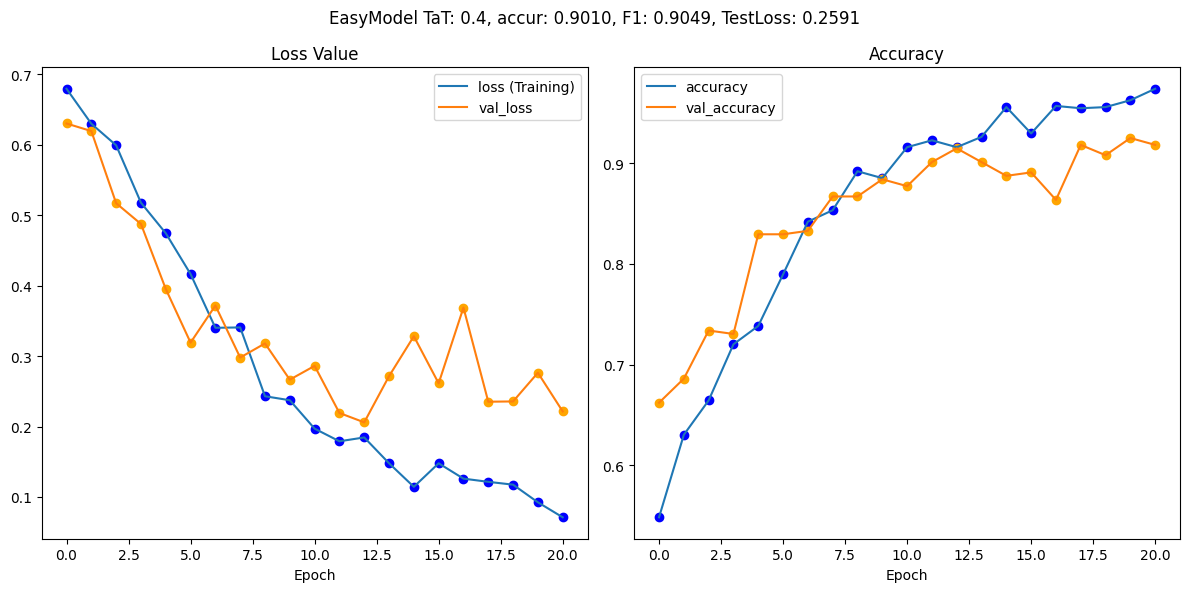

Train loss: 0.0711347758769989
Test val_loss: 0.22146275639533997
Train accuracy: 0.9738339185714722
Accuracy Score: 0.9010238907849829
F1 Score: 0.9049180327868852
Classification Report:
               precision    recall  f1-score   support

         0.0       0.91      0.89      0.90       142
         1.0       0.90      0.91      0.90       151

    accuracy                           0.90       293
   macro avg       0.90      0.90      0.90       293
weighted avg       0.90      0.90      0.90       293



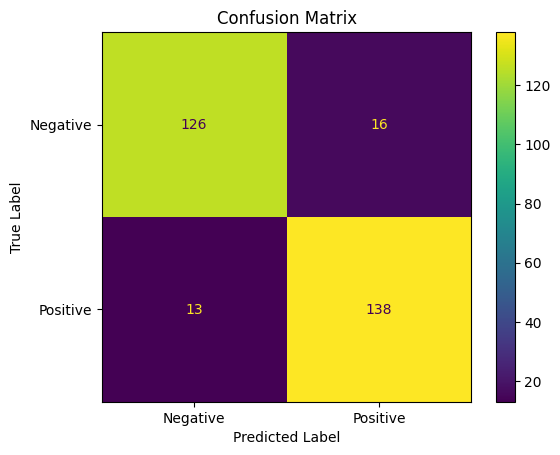

In [11]:
def build_SeparatedEASYmodel(F_input_shape, P_input_shape):
    force_input = Input(shape=F_input_shape, name='force_input')
    Fbranch1 = Sequential()
    Fbranch1.add(Conv1D(64, kernel_size=40, strides=8, activation='relu', input_shape=F_input_shape))
    Fbranch1.add(MaxPooling1D(pool_size=2))
    Fbranch1.add(Conv1D(128, kernel_size=20, strides=2, activation='relu'))
    Fbranch1.add(MaxPooling1D(pool_size=2))
    Fbranch1.add(Conv1D(256, kernel_size=4, activation='relu'))
    Fbranch1.add(GlobalMaxPooling1D())
    Fbranch1.add(Dense(128, activation='relu'))
    Fbranch1.add(Dropout(0.2))
    Fbranch1.add(Dense(64, activation='relu'))
    outF1 = Fbranch1(force_input)

    Fbranch2 = Sequential()
    Fbranch2.add(Conv1D(128, kernel_size=2,  activation='relu', input_shape=F_input_shape))
    Fbranch2.add(MaxPooling1D(pool_size=2))
    Fbranch2.add(Conv1D(64, kernel_size=8, strides=2, activation='relu'))
    Fbranch2.add(MaxPooling1D(pool_size=2))
    Fbranch2.add(Conv1D(128, kernel_size=4, activation='relu'))
    Fbranch2.add(Conv1D(64, kernel_size=2, activation='relu'))
    Fbranch2.add(GlobalMaxPooling1D())
    Fbranch2.add(Dropout(0.1))
    Fbranch2.add(Dense(64, activation='relu'))
    outF2 = Fbranch2(force_input)

    Fbranch3 = Sequential()
    Fbranch3.add(Conv1D(128, kernel_size=10, strides=4,  activation='relu', input_shape=F_input_shape))
    Fbranch3.add(MaxPooling1D(pool_size=2))
    Fbranch3.add(Conv1D(64, kernel_size=4, strides=2, activation='relu'))
    Fbranch3.add(MaxPooling1D(pool_size=2))
    Fbranch3.add(Conv1D(128, kernel_size=10, strides=2, activation='relu'))
    Fbranch3.add(Conv1D(64, kernel_size=2, activation='relu'))
    Fbranch3.add(GlobalMaxPooling1D())
    Fbranch3.add(Dropout(0.1))
    Fbranch3.add(Dense(64, activation='relu'))
    outF3 = Fbranch3(force_input)

    #####################################################################################
    
    pose_input = Input(shape=F_input_shape, name='pose_input')
    Pbranch = Sequential()
    Pbranch.add(Conv1D(64, kernel_size=40, strides=10, activation='relu', input_shape=P_input_shape))
    Pbranch.add(MaxPooling1D(pool_size=2))
    Pbranch.add(Conv1D(64, kernel_size=10, activation='relu'))
    Pbranch.add(MaxPooling1D(pool_size=2))
    Pbranch.add(Flatten())
    Pbranch.add(Dense(16, activation='relu'))
    outP = Pbranch(pose_input)
    
    merged = concatenate([outF1, outF2, outF3, outP])
    merged = Dropout(0.1)(merged)
    merged = Dense(64, activation='relu')(merged)
    merged = Dense(1, activation='sigmoid')(merged)
    separated_model = Model(inputs=[force_input, force_input, force_input, pose_input], outputs=merged)
    
    return separated_model

force_input_shape = (WS_B, 1)
pose_input_shape = POSE_IN_SHAPE

model = build_SeparatedEASYmodel(force_input_shape, pose_input_shape)
model.compile(optimizer=AdamW(), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# SPLITTING DATASET FORCE+POSE
X_force_data = X_data[:, :, :1]
X_pose_data  = X_data[:, :, 1:]

X_train_force,  X_temp_force = train_test_split(X_force_data, test_size=TEST_SIZE, random_state=42)
X_val_force,    X_test_force = train_test_split(X_temp_force , test_size=0.5, random_state=42)

X_train_pose,   X_temp_pose  = train_test_split(X_pose_data, test_size=TEST_SIZE, random_state=42)
X_val_pose,     X_test_pose  = train_test_split(X_temp_pose , test_size=0.5, random_state=42)

X_train = [X_train_force,   X_train_force,   X_train_force, X_train_pose]
X_val   = [X_val_force,     X_val_force,     X_val_force,   X_val_pose]
X_test  = [X_test_force,    X_test_force,    X_test_force,  X_test_pose]

y_train, y_temp = train_test_split(y_data, test_size=TEST_SIZE, random_state=42)
y_val  , y_test = train_test_split(y_temp, test_size=0.5, random_state=42)

#TRAIN THE MODEL
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=40, batch_size=32, validation_data=(X_val, y_val), verbose=1,callbacks=[early_stopping])
loss, accuracy = model.evaluate(X_test, y_test)

y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

f1 = f1_score(y_test, y_pred_binary)
accuracy = accuracy_score(y_test, y_pred_binary)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].scatter(range(len(history.history["loss"])), history.history["loss"], marker='o', color='blue')
axs[0].scatter(range(len(history.history["val_loss"])), history.history["val_loss"], marker='o', color='orange')
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()
# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
axs[1].scatter(range(len(history.history["accuracy"])), history.history["accuracy"], marker='o', color='blue')
axs[1].scatter(range(len(history.history["val_accuracy"])), history.history["val_accuracy"], marker='o', color='orange')
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.suptitle(f"EasyModel TaT: {TEST_SIZE}, accur: {accuracy:.4f}, F1: {f1:.4f}, TestLoss: {loss:.4f}")
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("Train accuracy:", history.history["accuracy"][-1])
print("Accuracy Score:", accuracy)

print("F1 Score:", f1)
print("Classification Report:\n", classification_report(y_test, y_pred_binary))
plot_confusion_matrix(y_test, y_pred_binary)
    